## Problem Definition and Literature Review

Abstract:   
As music studies in social media, psychology, and cultural studies have increased, sentiment analysis on song lyrics has also become a popular research area. In this research, we....

1.Introduction:    
Song lyrics, as a form of literary expression, contain rich vocabulary and narrative structures imbued with emotions. Conducting sentiment analysis on lyrics can reveal common emotional tendencies in popular music, helping to understand the emotional expressions of the public and providing data support for interdisciplinary research in psychology, cultural studies, and social media.

2.Literature Review:    
2.1 Fundamental Theories and Methods of Sentiment Analysis    
Sentiment analysis methods can generally be divided into dictionary-based and machine learning-based approaches:

2.2.1 Dictionary-Based Methods: This approach relies on sentiment lexicons, such as the NRC Word-Emotion Association Lexicon, AFINN, and SentiWordNet. These lexicons contain a large number of emotional words, with each word corresponding to a certain sentiment value (e.g., positive, negative, or neutral). By matching words in the lyrics with the lexicon, it’s possible to calculate the frequency of different emotions and generate sentiment scores. This method is straightforward, but it has limitations in capturing implicit or ambiguous emotional expressions in lyrics.

2.2.2 Machine Learning-Based Methods: Recently, deep learning models, such as Convolutional Neural Networks (CNN), Long Short-Term Memory Networks (LSTM), and Attention Mechanisms, have been widely used in sentiment analysis. With the development of pre-trained language models (such as BERT and GPT), sentiment analysis has become more effective at capturing contextual information within lyrics, resulting in more accurate emotion classification. These models are capable of capturing complex syntax and semantic relationships in lyrics.

2.2 Previous Research   
There are mainly three types of research that have been conducted previously: first, studies on emotional trends in popular songs over time, which show shifts from positive to negative tones in response to societal changes (Napier & Shamir, 2018); second, genre-specific analyses revealing unique emotional expressions, such as anger in rap and sadness in country music (Krause & North, 2020); and third, investigations into theme-based emotional patterns, where love songs generally express positivity while social issue songs convey anger and sadness (Hu & Downie, 2021). Additionally, cross-cultural research highlights differences, with Western pop often expressing extreme emotions, while Asian pop favors warmer, more moderate tones (Liao et al., 2022).

reference:   datasource：from2000 to 2023 ;pretrained_model source:

## Data preprocessing

#### data cleaning

In [ ]:
import pandas as pd
# load original dataset
data_original = pd.read_csv("/content/billboard_24years_lyrics_spotify.csv")
print(data_original.head(10))

   ranking                 song       band_singer  \
0        1              Breathe        Faith Hill   
1        2               Smooth           Santana   
2        2               Smooth        Rob Thomas   
3        3          Maria Maria           Santana   
4        3          Maria Maria   The Product G&B   
5        4         I Wanna Know               Joe   
6        5  Everything You Want  Vertical Horizon   
7        6          Say My Name   Destiny's Child   
8        7   I Knew I Loved You     Savage Garden   
9        8               Amazed          Lonestar   

                                             songurl            titletext  \
0                    /wiki/Breathe_(Faith_Hill_song)              Breathe   
1                        /wiki/Smooth_(Santana_song)               Smooth   
2                        /wiki/Smooth_(Santana_song)               Smooth   
3                                  /wiki/Maria_Maria          Maria Maria   
4                              

In [ ]:
# #Filter out rows where the year is between 2000 and 2023
# data = data_original[(data_original['year'] >= 2000) & (data_original['year'] <= 2023)]
# print("Number of rows in cleaned dataset:", data.shape[0])

# delete duplicate rows based on the 'lyrics' column
data= data_original.drop_duplicates(subset="lyrics")

# # drop rows where the 'lyrics' column has NaN or empty values
# data = data.dropna(subset=['lyrics'])
# print("Number of rows in cleaned dataset:", data.shape[0])

# Reset the index after dropping rows
data = data.reset_index(drop=True)

print("Number of rows in cleaned dataset:", data.shape[0])

Number of rows in cleaned dataset: 2330


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save results to csv
data.to_csv('/content/drive/MyDrive/01_cleaned_data.csv')

#### data labeling

Run Emotion-English-DistilRoBERTa-base model

In [ ]:
# install the transformers library
!pip install transformers

In [ ]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    report_to="none"
)

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model,args=training_args)

In [ ]:
# choose texts
text_column = "lyrics"
pred_texts = data[text_column].dropna().astype('str').tolist()

Classify texts with model

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts, truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# Run predictions
predictions = trainer.predict(pred_dataset)
print(predictions[:10])

In [ ]:
pred_array = predictions.predictions
label_pred_save = pd.DataFrame(pred_array, columns=[f"label_{i}" for i in range(pred_array.shape[1])])
# label_pred_save.to_csv('/content/drive/MyDrive/label_predictions.csv', index=False)
print("Rows in original data:", data.shape[0])
print("Rows in predictions data:", label_pred_save.shape[0])

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [ ]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(temp)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

In [ ]:
# Check the lengths of each array
print(f"Length of pred_texts: {len(pred_texts)}")
print(f"Length of preds: {len(preds)}")
print(f"Length of labels: {len(labels)}")
print(f"Length of scores: {len(scores)}")
print(f"Length of anger: {len(anger)}")
print(f"Length of disgust: {len(disgust)}")
print(f"Length of fear: {len(fear)}")
print(f"Length of joy: {len(joy)}")
print(f"Length of neutral: {len(neutral)}")
print(f"Length of sadness: {len(sadness)}")
print(f"Length of surprise: {len(surprise)}")


export results

In [ ]:
# Create a new DataFrame for predictions, labels, and scores
pred_df = pd.DataFrame({
     'pred': preds,        # Predicted labels
    'label': labels,      # True labels
    'score': scores,      # Prediction scores
    'anger': anger,
    'disgust': disgust,
    'fear': fear,
    'joy': joy,
    'neutral': neutral,
    'sadness': sadness,
    'surprise': surprise
})

# Combine the original features with the new predictions DataFrame
df_combined = pd.concat([data, pred_df], axis=1)

# Display the first few rows of the combined DataFrame
df_combined.head()


In [ ]:
# save results to csv
df_combined.to_csv('/content/drive/MyDrive/02_labelled_data.csv')

#### dataset overview


In [ ]:

label_counts = df_combined['label'].value_counts()

label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Emotion', 'Count']
print(label_counts_df)

    Emotion  Count
0   neutral    676
1     anger    490
2      fear    482
3   sadness    377
4  surprise    105
5   disgust    105
6       joy     95


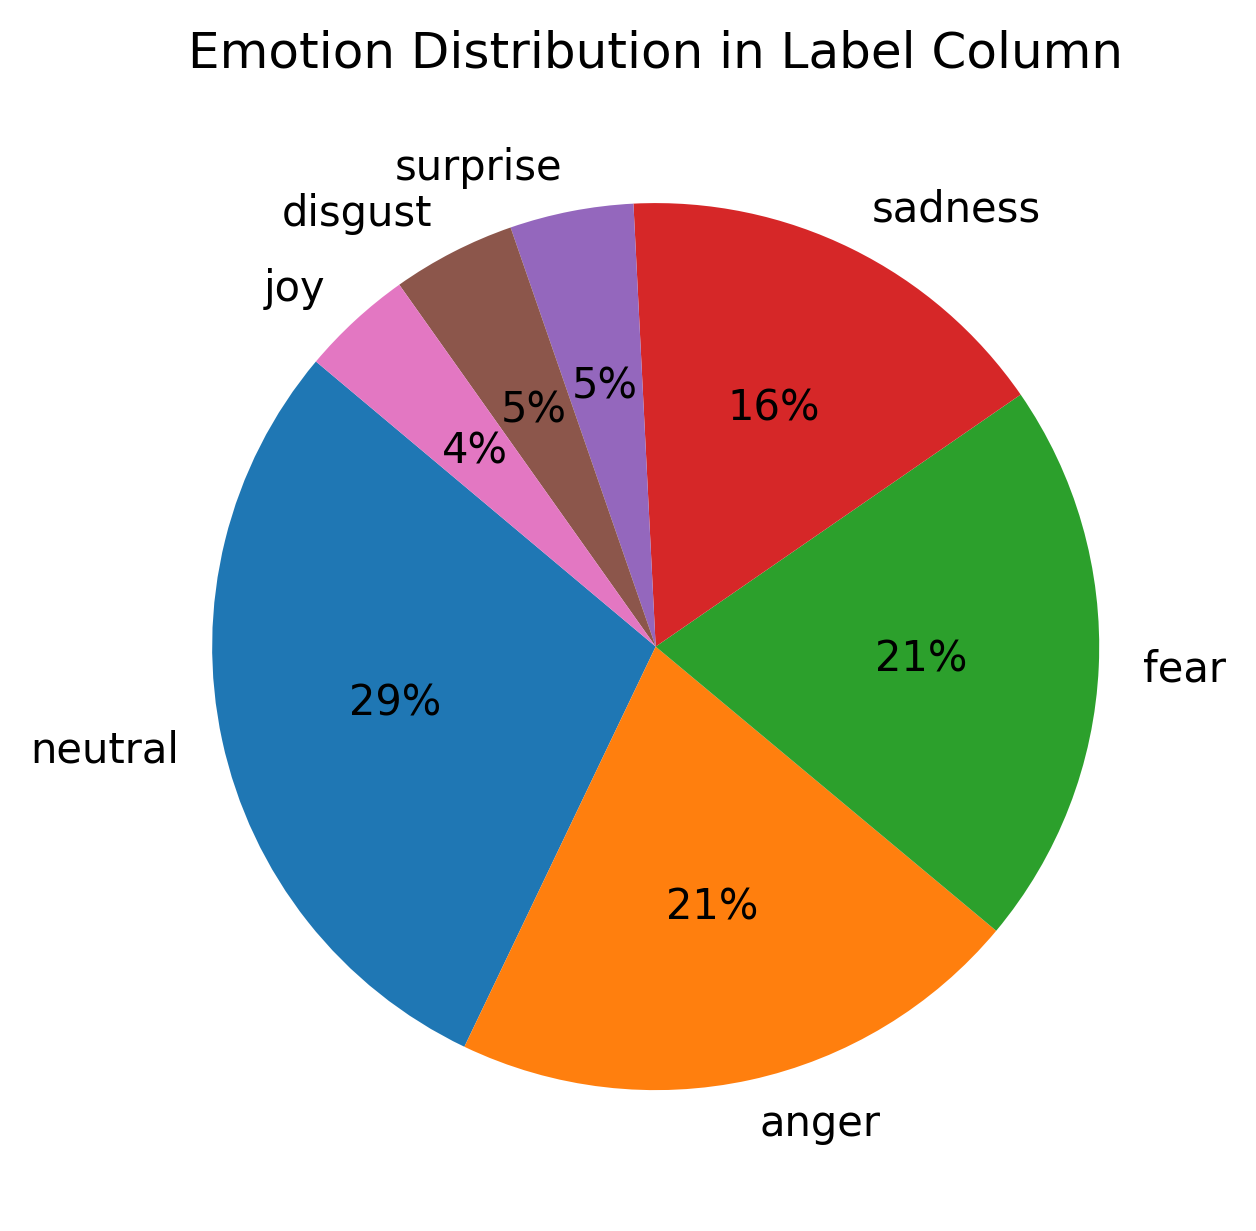

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.pie(label_counts, labels=label_counts.index, autopct='%1.0f%%', startangle=140)
plt.title('Emotion Distribution in Label Column')
plt.show()

## data preprocessing

In [ ]:
# df_combined = pd.read_csv('/content/drive/MyDrive/02_labelled_data.csv')

In [ ]:
!pip install pyspellchecker
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

# preprocess the data in the "lyrics" column
def pre_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Spell correction
    # spell = SpellChecker()
    # text = ' '.join(spell.correction(word) if spell.correction(word) is not None else word for word in text.split())

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from tqdm import tqdm

tqdm.pandas()

df_combined['lyrics'] = df_combined['lyrics'].progress_apply(pre_text)

# Check the cleaned data
print(df_combined['lyrics'].head(10))

100%|██████████| 2330/2330 [00:11<00:00, 197.86it/s]

0    feel magic floating air get way watch sunlight...
1    man hot one like seven inch midday sun well he...
2    lady gent turn sound system sound carlos santa...
3    turn sound system sound carlos santana gmbs gh...
4    yeah ohoh yeah alright oh oh oh amazing knock ...
5    somewhere there speaking already coming oh ris...
6    darkchild 99 say name say name one around say ...
7    mmm ooh oh maybe intuition thing dont question...
8    every time eye meet feeling inside almost take...
9    fall along way pick dust get tired make breath...
Name: lyrics, dtype: object


In [ ]:
df_combined.to_csv('/content/drive/MyDrive/03_pre_text_data.csv')

## Two models

In [80]:
# import pandas as pd
# df_combined = pd.read_csv('/content/drive/MyDrive/03_pre_text_data.csv')

In [81]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [82]:
# Load data
data = df_combined

texts = data['lyrics'].values
labels = data['label'].values

# Encode labels (if labels are strings, you may need LabelEncoder first)
label_map = {label: idx for idx, label in enumerate(np.unique(labels))}
labels = np.array([label_map[label] for label in labels])

# Text preprocessing
max_words = 10000  # Size of the vocabulary
max_len = 100      # Maximum length of each text sequence

# Tokenize and pad the text sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = labels


#### CNN

In [106]:
# Split data into training and test sets
X_train_0, X_test, y_train_0, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
all_train_accuracies = []
all_val_accuracies = []

for train_index, val_index in kf.split(X_train_0):
    print(f'Training fold {fold_no}...')

# Split data into train and validation sets
X_train, X_val = X_train_0[train_index], X_train_0[val_index]
y_train, y_val = y_train_0[train_index], y_train_0[val_index]

# Build the CNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),  # Embedding layer
    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.001)),  # Convolution layer with 128 filters and kernel size of 5
    Dropout(0.7),
    GlobalMaxPooling1D(),  # Global max pooling layer
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # Fully connected layer with ReLU activation
    Dropout(0.7),  # Dropout layer to prevent overfitting
    Dense(len(label_map), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Metric to monitor
    patience=3,                # Number of epochs to wait for improvement
    mode='max',                # Set mode to 'max' for metrics that should be maximized
    restore_best_weights=True  # Restore the model to the best weights
)


# Train the model
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Train the model on the current fold
history = model.fit(
        X_train, y_train,
        epochs=8,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

# Append the history to list
all_train_accuracies.append(history.history['accuracy'])
all_val_accuracies.append(history.history['val_accuracy'])

fold_no += 1

# compute average accuracy for epoch
avg_train_accuracy = np.mean(all_train_accuracies, axis=0)
avg_val_accuracy = np.mean(all_val_accuracies, axis=0)

#predict y using test data
y_pred = np.argmax(model.predict(X_test), axis=1)

Training fold 1...
Training fold 1...
Training fold 1...
Training fold 1...
Training fold 1...
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.1803 - loss: 2.0482 - val_accuracy: 0.2849 - val_loss: 1.9918
Epoch 2/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.2648 - loss: 1.9273 - val_accuracy: 0.2957 - val_loss: 1.9554
Epoch 3/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3171 - loss: 1.8440 - val_accuracy: 0.3118 - val_loss: 1.9221
Epoch 4/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3341 - loss: 1.7957 - val_accuracy: 0.3495 - val_loss: 1.8917
Epoch 5/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4057 - loss: 1.6732 - val_accuracy: 0.3978 - val_loss: 1.8622
Epoch 6/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5159 - loss: 1.5464 - val_accuracy: 0.4005 - val_loss: 1.8283
Epoch 7/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5819 - loss: 1.3803 - val_accuracy: 0.4220 - val_loss: 1.7980
Epoch 8/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6248 - loss: 1.2710 - val_accuracy: 0.4462 - val_loss: 1.7760
15

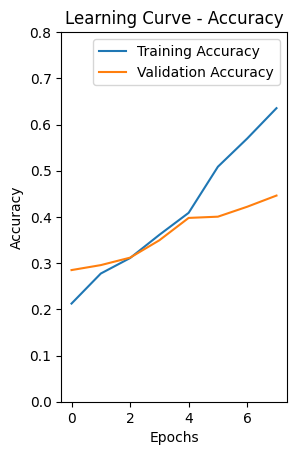

In [107]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Training Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 0.8)
plt.title('Learning Curve - Accuracy')
plt.legend()


# # Plot learning curves for each fold
# plt.figure(figsize=(12, 8))
# for i, history in enumerate(history_per_fold, 1):
#     plt.plot(history.history['accuracy'], label=f'Training Accuracy Fold {i}')
#     plt.plot(history.history['val_accuracy'], linestyle='--', label=f'Validation Accuracy Fold {i}')
# plt.title('Learning Curves Across Folds')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [108]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.43      0.47      0.45        91
     disgust       0.00      0.00      0.00        19
        fear       0.33      0.41      0.36        96
         joy       0.00      0.00      0.00        23
     neutral       0.40      0.65      0.50       137
     sadness       0.54      0.19      0.28        75
    surprise       0.00      0.00      0.00        25

    accuracy                           0.40       466
   macro avg       0.24      0.25      0.23       466
weighted avg       0.36      0.40      0.35       466

Confusion Matrix:
[[43  0 18  0 28  2  0]
 [13  0  1  0  5  0  0]
 [12  0 39  0 40  5  0]
 [ 1  0  7  0 14  1  0]
 [23  0 21  0 89  4  0]
 [ 4  0 26  0 31 14  0]
 [ 4  0  6  0 15  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluation

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
label_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
label_names = [label_names[label] for label in unique_labels]

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion_mat, index=label_names, columns=label_names)

# Plotting the confusion matrix
plt.figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, cbar=True)
plt.title('Emotion Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.show()


In [ ]:
# Extract accuracy and validation accuracy from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy
plt.figure(dpi=300)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### BiLSTM

In [76]:
# # Load data
# data = df_combined

# texts = data['lyrics'].values
# labels = data['label'].values

# # Encode labels (if labels are strings, you may need LabelEncoder first)
# label_map = {label: idx for idx, label in enumerate(np.unique(labels))}
# labels = np.array([label_map[label] for label in labels])

# # Text preprocessing
# max_words = 10000  # Size of the vocabulary
# max_len = 100      # Maximum length of each text sequence

# # Tokenize and pad the text sequences
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)
# X = pad_sequences(sequences, maxlen=max_len)

In [102]:
# Split data into training and test sets
X_train_0, X_test, y_train_0, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
all_train_accuracies = []
all_val_accuracies = []

for train_index, val_index in kf.split(X_train_0):
    print(f'Training fold {fold_no}...')

# Split data into train and validation sets
X_train, X_val = X_train_0[train_index], X_train_0[val_index]
y_train, y_val = y_train_0[train_index], y_train_0[val_index]


# Build the BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),  # Embedding layer
    Bidirectional(LSTM(64, return_sequences=True)),  # First BiLSTM layer with 64 units
    Dropout(0.6),  # Dropout layer to prevent overfitting
    Bidirectional(LSTM(32)),  # Second BiLSTM layer with 32 units
    Dense(32, activation='relu',kernel_regularizer=l2(0.001)),  # Fully connected layer with ReLU activation
    Dropout(0.6),  # Dropout layer
    Dense(len(label_map), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor
        patience=3,  # Number of epochs to wait for improvement
        mode='max',  # Set mode to 'max' for metrics that should be maximized
        restore_best_weights=True  # Restore the model to the best weights
    )

# Train the model
# history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Train the model on the current fold
history = model.fit(
        X_train, y_train,
        epochs=8,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
)

# Append the history to list
all_train_accuracies.append(history.history['accuracy'])
all_val_accuracies.append(history.history['val_accuracy'])

fold_no += 1

# compute average accuracy for epoch
avg_train_accuracy = np.mean(all_train_accuracies, axis=0)
avg_val_accuracy = np.mean(all_val_accuracies, axis=0)

#predict y using test data
y_pred = np.argmax(model.predict(X_test), axis=1)

Training fold 1...
Training fold 1...
Training fold 1...
Training fold 1...
Training fold 1...
Epoch 1/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.2146 - loss: 1.9389 - val_accuracy: 0.2849 - val_loss: 1.8264
Epoch 2/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.2661 - loss: 1.8129 - val_accuracy: 0.2876 - val_loss: 1.6953
Epoch 3/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.3950 - loss: 1.5551 - val_accuracy: 0.3199 - val_loss: 1.6900
Epoch 4/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 0.5357 - loss: 1.3317 - val_accuracy: 0.3495 - val_loss: 1.7457
Epoch 5/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 284ms/step - accuracy: 0.6290 - loss: 1.0210 - val_accuracy: 0.3710 - val_loss: 1.9352
Epoch 6/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 231ms/step - accuracy: 0.7107 - loss: 0.8473 - val_accuracy: 0.3414 - val_loss: 2.0147
Epoch 7/8
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 255ms/step - accuracy: 0.7682 - loss: 0.6665 - val_accuracy: 0.3387 - val_loss: 2.4112
Epoch 8/8

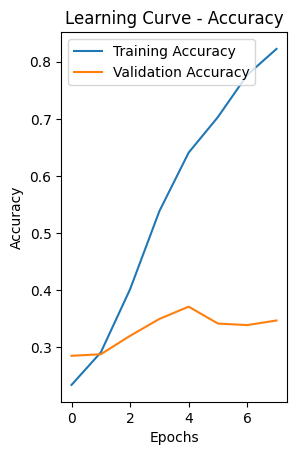

In [103]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Training Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Accuracy')
plt.legend()


In [104]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.37      0.38      0.38        91
     disgust       0.00      0.00      0.00        19
        fear       0.32      0.36      0.34        96
         joy       0.40      0.09      0.14        23
     neutral       0.33      0.41      0.36       137
     sadness       0.23      0.24      0.23        75
    surprise       0.00      0.00      0.00        25

    accuracy                           0.31       466
   macro avg       0.23      0.21      0.21       466
weighted avg       0.29      0.31      0.29       466

Confusion Matrix:
[[35  0 11  1 35  9  0]
 [10  0  2  0  7  0  0]
 [11  1 35  0 31 18  0]
 [ 1  2  5  2 10  3  0]
 [23  1 34  1 56 22  0]
 [12  1 20  1 23 18  0]
 [ 3  0  3  0 10  9  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### model comparison